# Gibs Sampling and LDA

### Problem 1

In [45]:
import numpy as np
from math import sqrt
from scipy.stats import invgamma
from scipy.stats import norm
from scipy.stats import gaussian_kde
from matplotlib import pyplot as plt
%matplotlib inline

In [20]:
y = np.loadtxt("examscores.csv")

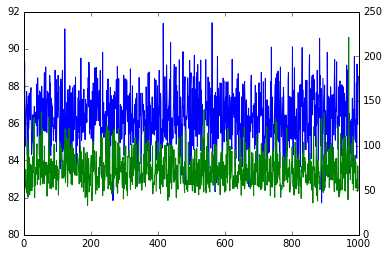

In [168]:
def gibbs(y, mu0, sigma02, alpha, beta, n_samples):
    """
    Assuming a likelihood and priors
        y_i
         ~ N(mu, sigma2),
        mu
         ~ N(mu0, sigma02),
        sigma2 ~ IG(alpha, beta),
    sample from the posterior distribution
        P(mu, sigma2 | y, mu0, sigma02, alpha, beta)
    using a gibbs sampler.
    
    Parameters
    ----------
    y : ndarray of shape (N,)
        The data
    mu0 : float
        The prior mean parameter for mu
    sigma02 : float > 0
        The prior variance parameter for mu
    alpha : float > 0
        The prior alpha parameter for sigma2
    beta : float > 0
        The prior beta parameter for sigma2
    n_samples : int
        The number of samples to draw50
    Returns
    -------
    samples : ndarray of shape (n_samples,2)
        1st col = mu samples, 2nd col = sigma2 samples
    """
    Sig2 = np.empty(n_samples)
    Mu = np.empty(n_samples)
    mu = y.mean()
    sig2 = 50
    N = y.shape[0]
    for k in xrange(n_samples):

            sig2s = 1./(1./ sigma02 + N/sig2)
            mus = sig2s * (mu0/sigma02 + 1/sig2 *y.sum() )
            mu = norm.rvs(mus,scale=sqrt(sig2s))
            Mu[k] = mu
            
            alphas = alpha + N/2.
            betas = beta + 1/2.*((y - mu)**2).sum()
            sig2 = invgamma.rvs(alphas,scale=betas)
            Sig2[k] = sig2
            

    return np.vstack((Mu,Sig2)).T

ret = gibbs(y,80,16,3,50,1000)
mu_samples = ret[:,0]
sig2_samples = ret[:,1]
fig, ax1 = plt.subplots()
ax1.plot(np.arange(1000),ret[:,0],c='b')
ax2 = ax1.twinx()
ax2.plot(np.arange(1000),ret[:,1],c='g')
plt.show()

In [190]:
### Problem 2

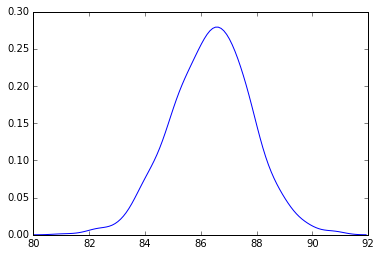

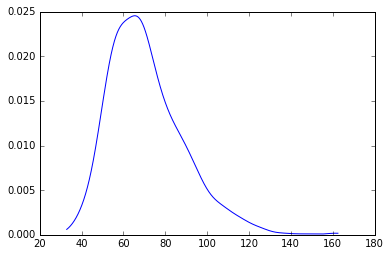

In [169]:
ret = gibbs(y,80,16,3,50,1000)
mu_samples = ret[:,0]
sig2_samples = ret[:,1]

mu_kernel = gaussian_kde(mu_samples)
x_min = min(mu_samples) - 1
x_max = max(mu_samples) + 1
x = np.arange(x_min, x_max, step=0.1)
plt.plot(x,mu_kernel(x))
plt.show()

sig2_kernel = gaussian_kde(sig2_samples)
x_min = min(sig2_samples) - 1
x_max = max(sig2_samples) + 1
x = np.arange(x_min, x_max, step=0.1)
plt.plot(x,sig2_kernel(x))
plt.show()

### Problem 3

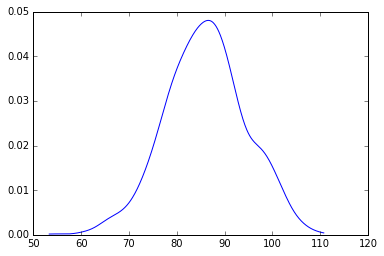

In [170]:
ret = gibbs(y,80,16,3,50,1000)
mu_samples = ret[:,0]
sig2_samples = ret[:,1]
y_samples = np.empty(1000)
for i in range(1000):
    y_samples[i]= norm.rvs(mu_samples[i],scale=sqrt(sig2_samples[i]))
y_kernel = gaussian_kde(y_samples)
x_min = min(y_samples) - 1
x_max = max(y_samples) + 1
x = np.arange(x_min, x_max, step=0.1)
plt.plot(x,y_kernel(x))
plt.show()

### Problem 4-6

In [175]:
import numpy as np
from scipy.special import gammaln
import string

def loadStopwords(filename):
    """ This function is given. """
    infile = open(filename,'r')
    stopwords = infile.readlines()
    for i in xrange(len(stopwords)):
        stopwords[i] = stopwords[i].rstrip()
    stopwords.append('')
    return stopwords

class LDACGS(object):

    def __init__(self, n_topics, alpha = 0.1, beta = 0.1):
        """ This function is given. """
        self.n_topics = n_topics
        self.alpha = alpha
        self.beta = beta

    def buildCorpus(self,filename,stopwords=None):
        """ This function is given. """
        infile = open(filename,'r')
        doclines = [line.rstrip().translate(string.maketrans("",""),string.punctuation).lower().split(' ') for line in infile]
        n_docs = len(doclines)
        self.vocab = []
        for i in xrange(n_docs):
            self.vocab += doclines[i]
        self.vocab = list(set(self.vocab))
        if stopwords != None:
            self.vocab = np.sort(self._removeStopwords(stopwords)).tolist()
        self.documents = []
        for i in xrange(n_docs):
            self.documents.append({})
            for j in xrange(len(doclines[i])):
                if doclines[i][j] in self.vocab:
                    self.documents[i][j] = self.vocab.index(doclines[i][j])

    def initialize(self):
        self.n_words = len(self.vocab)
        self.n_docs = len(self.documents)

        # initialize the three count matrices
        # the (i,j) entry of self.nmz is # of words in document i assigned to topic j
        self.nmz = np.zeros((self.n_docs,self.n_topics))
        # the (i,j) entry of self.nzw is # of times term j is assigned to topic i
        self.nzw = np.zeros((self.n_topics,self.n_words))
        # the (i)-th entry is the number of times topic i is assigned in the corpus
        self.nz = np.zeros(self.n_topics)

        # initialize the topic assignment dictionary
        self.topics = {} # key-value pairs of form (m,i):z
        for m in xrange(self.n_docs):
            for i in self.documents[m]:
                # Get random topic assignment, i.e. z = ...
                z = np.random.randint(0,self.n_topics)
                # Increment count matrices
                self.nzw[z,self.documents[m][i]] += 1
                self.nmz[m,z]+=1
                self.nz[z] += 1
                # Store topic assignment, i.e. self.topics[(m,i)]=z
                self.topics[(m,i)] = z
                
    def sample(self,filename, burnin=100, sample_rate=10, n_samples=10, stopwords=None):
        self.buildCorpus(filename,stopwords)
        self.initialize()
        self.total_nzw = np.zeros((self.n_topics,self.n_words))
        self.total_nmz = np.zeros((self.n_docs,self.n_topics))
        self.logprobs = np.zeros(burnin + sample_rate*n_samples)
        for i in xrange(burnin):
            # Sweep and store log likelihood
            self._sweep()
            self.logprobs[i] = self._loglikelihood()
            print "Iteration {} of {} in burn in".format(i,burnin)
        for i in xrange(n_samples*sample_rate):
            # Sweep and store log likelihood
            self._sweep()
            self.logprobs[i+burnin] = self._loglikelihood()
            print "Iteration {} of {} in sampling".format(i,n_samples*sample_rate)
            if not i%sample_rate:
                # accumulate counts
                self.total_nzw += self.nzw
                self.total_nmz += self.nmz

    def phi(self):
        """ This function is given. """
        phi = self.total_nzw + self.beta
        self._phi = phi / np.sum(phi, axis=1)[:,np.newaxis]

    def theta(self):
        """ This function is given. """
        theta = self.total_nmz + self.alpha
        self._theta = theta / np.sum(theta, axis=1)[:,np.newaxis]

    def topterms(self,n_terms=10):
        """ This function is given. """
        vec = np.atleast_2d(np.arange(0,self.n_words))
        topics = []
        for k in xrange(self.n_topics):
            probs = np.atleast_2d(self._phi[k,:])
            mat = np.append(probs,vec,0)
            sind = np.array([mat[:,i] for i in np.argsort(mat[0])]).T
            topics.append([self.vocab[int(sind[1,self.n_words - 1 - i])] for i in xrange(n_terms)])
        return topics

    def toplines(self,n_lines=5):
        """ This function is given. """
        lines = np.zeros((self.n_topics,n_lines))
        for i in xrange(self.n_topics):
            args = np.argsort(self._theta[:,i]).tolist()
            args.reverse()
            lines[i,:] = np.array(args)[0:n_lines] + 1
        return lines

    def _removeStopwords(self,stopwords):
        """ This function is given. """
        output = []
        for x in self.vocab:
            if x not in stopwords:
                output.append(x)
        return output

    def _conditional(self, m, w):
        """
        This function is given. Compute the conditional distribution of
        the topic corresponding to document m and word index w.
        Returns a distribution vector of length self.n_topics.
        """
        dist = (self.nmz[m,:] + self.alpha) * (self.nzw[:,w] + self.beta) / (self.nz + self.beta*self.n_words)
        return dist/sum(dist)

    def _sweep(self):
        for m in xrange(self.n_docs):
            for i in self.documents[m]:
                # Retrieve vocab index for i^th word in document m
                w = self.documents[m][i]
                # Retrieve topic assignment for i^th word in document m
                z = self.topics[(m,i)]
                # Decrement count matrices
                self.nzw[z,w] -=1
                self.nmz[m,z] -= 1
                self.nz[z] -= 1
                # Get conditional distribution
                dist = self._conditional(m,w)
                
                # Sample new topic assignment
                z = np.random.multinomial(1,dist).argmax()
                # Increment count matrices
                self.nzw[z,w] +=1
                self.nmz[m,z] += 1
                self.nz[z] += 1
                # Store new topic assignment
                self.topics[(m,i)] = z

    def _loglikelihood(self):
        """ This function is given. """
        lik = 0

        for z in xrange(self.n_topics):
            lik += np.sum(gammaln(self.nzw[z,:] + self.beta)) - gammaln(np.sum(self.nzw[z,:] + self.beta))
            lik -= self.n_words * gammaln(self.beta) - gammaln(self.n_words*self.beta)

        for m in xrange(self.n_docs):
            lik += np.sum(gammaln(self.nmz[m,:] + self.alpha)) - gammaln(np.sum(self.nmz[m,:] + self.alpha))
            lik -= self.n_topics * gammaln(self.alpha) - gammaln(self.n_topics*self.alpha)

        return lik

### Problem 7

In [179]:
ldacgs = LDACGS(20)
stopwords = loadStopwords("stopwords.txt")
ldacgs.sample("reagan.txt",100,10,10,stopwords)

Iteration 0 of 100 in burn in
Iteration 1 of 100 in burn in
Iteration 2 of 100 in burn in
Iteration 3 of 100 in burn in
Iteration 4 of 100 in burn in
Iteration 5 of 100 in burn in
Iteration 6 of 100 in burn in
Iteration 7 of 100 in burn in
Iteration 8 of 100 in burn in
Iteration 9 of 100 in burn in
Iteration 10 of 100 in burn in
Iteration 11 of 100 in burn in
Iteration 12 of 100 in burn in
Iteration 13 of 100 in burn in
Iteration 14 of 100 in burn in
Iteration 15 of 100 in burn in
Iteration 16 of 100 in burn in
Iteration 17 of 100 in burn in
Iteration 18 of 100 in burn in
Iteration 19 of 100 in burn in
Iteration 20 of 100 in burn in
Iteration 21 of 100 in burn in
Iteration 22 of 100 in burn in
Iteration 23 of 100 in burn in
Iteration 24 of 100 in burn in
Iteration 25 of 100 in burn in
Iteration 26 of 100 in burn in
Iteration 27 of 100 in burn in
Iteration 28 of 100 in burn in
Iteration 29 of 100 in burn in
Iteration 30 of 100 in burn in
Iteration 31 of 100 in burn in
Iteration 32 of 10

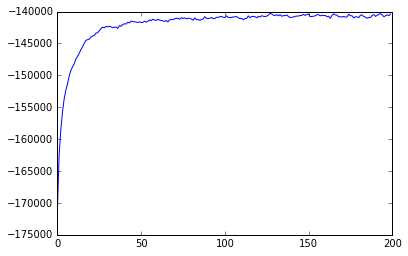

In [180]:
plt.plot(ldacgs.logprobs)
plt.show()

### Problem 8

In [187]:
ldacgs.phi()
ldacgs.theta()
topTerms = ldacgs.topterms(10)
topics = ["welfare","economy","family","government","president","budget","taxes","resources","america in global trade","bipartisan politics",
          "space","victims","future","Ronald Reagan","heroes","defense","washington","freedom","people's government","private industry"]

# Metropolis
### Problem 1

In [186]:
import numpy as np
import matplotlib.pyplot as plt

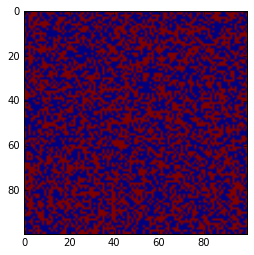

In [67]:
def init_ising(n):
    return 2*np.random.randint(0,2,size=(n,n)) - 1
plt.imshow(init_ising(100))
plt.show()

### Problem 2

In [81]:
def comp_energy(sig):
    return -(sig*np.roll(sig,1,axis=0) + sig*np.roll(sig,1,axis=1)).sum()

### Problem 3

In [ ]:
def proposal(n):
    return np.random.randint(0,n),np.random.randint(0,n)

### Problem 4

In [158]:
def newEnergy(sig,h,prop):
    n = sig.shape[0]
    add = 0
    for i in ((0,1),(1,0),(0,-1),(-1,0)):
        ind = (np.array(i) + np.array(prop))%n
        add += 2*sig[prop]*sig[ind[0],ind[1]]
    return h + add

### Problem 5

In [159]:
def accept(curH,propH,beta):
    return (propH < curH or 
            np.random.binomial(1,np.exp(beta*(curH - propH))) ==1)

### Problem 6

In [160]:
def metropolis(n, beta,burnIn,n_samples):
    sigs = np.empty((n_samples//100+1,n,n))
    nbetaH = np.empty(burnIn+n_samples+1)
    
    sig = init_ising(n)
    H = comp_energy(sig)
    """ 
    Use the Metropolis algorithm to sample from posterior.

    Parameters
    ----------
    x0 : ndarray of shape (2,)
        The first entry is mu, the second entry is sigma2
    s : float > 0 
        The standard deviation parameter for the proposal function
    n_samples : int 
        The number of samples to generate

    Returns
    -------
    draws : ndarray of shape (n_samples, 2)
        The MCMC samples
    logprobs : ndarray of shape (n_samples)
        The log density of the samples
    accept_rate : float
        The proportion of proposed samples that were accepted
    """ 
    accept_counter = 0 
    
    for i in xrange(n_samples+burnIn):
        if(i >= burnIn and ((i - burnIn) % 100) == 0):
            #print "Write %d" % ((i - burnIn)//100)
            sigs[(i - burnIn)//100] = sig.copy()
        nbetaH[i] = -beta*H
        
        prop = proposal(n)
        propH = newEnergy(sig,H,prop)
        if accept(H,propH,beta):
            accept_counter += 1
            sig[prop]*= -1
            H = propH
    sigs[-1] = sig
    nbetaH[-1] = -beta*H
    
    return sigs,nbetaH,accept_counter/float(burnIn + n_samples)

### Problem 6

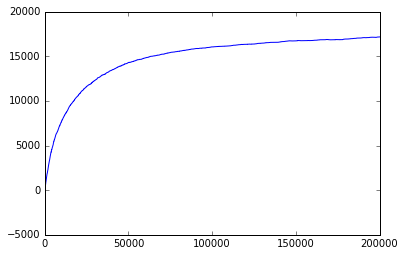

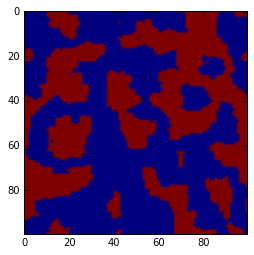

In [163]:
sigs,nbetaH,ac = metropolis(100,1,
        burnIn=(200000-50*100),n_samples=50*100)
plt.plot(nbetaH)
plt.show()
plt.imshow(sigs[-1])
plt.show()

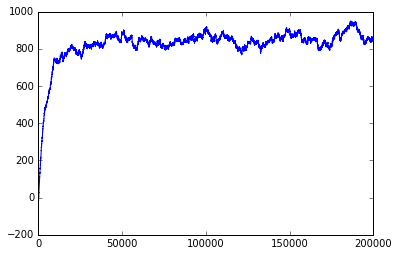

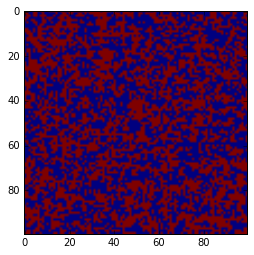

In [164]:
sigs,nbetaH,ac = metropolis(100,.2,
        burnIn=(200000-50*100),n_samples=50*100)
plt.plot(nbetaH)
plt.show()
plt.imshow(sigs[-1])
plt.show()